# NLP & Text Mining <br> _A look into a year of dating_ 
***

### Contents
- [Intro](#intro)
- [Accessing Raw Data](#access)
- [Processing of Data](#process)
- [Text Analysis](#analysis)
- [Creating Wordcloud](#wordcloud)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Intro
***
This document outlines the process of putting together a suprise gift for my girlfriend for our anniversary. I thought the idea of creating a word cloud of all of our texts over the past year we have been dating would be a perfect gift for us to share.

<a id='access'></a>
### Accessing Raw Data
This is a project I had considered doing for a while now, but due to the hurdle of accessing the actual phone data (as I have  never attempted to), I hadn't prioitized it. It's actually pretty straightforward though, as the backup file is easily accesible through a SQLite database. I found this article very helpful, http://osxdaily.com/2010/07/08/read-iphone-sms-backup/.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy as sp
import sklearn as sk
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
import codecs
import re
import copy
import collections
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "C:/Users/earthur/Desktop/DS Projects/NLP Text Mining/"
database = path + "3d0d7e5fb2ce288813306e4d4636395e047a3d28"

con = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", con)
tables

,type,name,tbl_name,rootpage,sql
0,table,_SqliteDatabaseProperties,_SqliteDatabaseProperties,2,CREATE TABLE _SqliteDatabaseProperties (key TE...
1,table,deleted_messages,deleted_messages,4,CREATE TABLE deleted_messages (ROWID INTEGER P...
2,table,sqlite_sequence,sqlite_sequence,6,"CREATE TABLE sqlite_sequence(name,seq)"
3,table,chat_handle_join,chat_handle_join,7,CREATE TABLE chat_handle_join (chat_id INTEGER...
4,table,sync_deleted_messages,sync_deleted_messages,9,CREATE TABLE sync_deleted_messages (ROWID INTE...
5,table,message_processing_task,message_processing_task,11,CREATE TABLE message_processing_task (ROWID IN...
6,table,handle,handle,13,CREATE TABLE handle (ROWID INTEGER PRIMARY KEY...
7,table,sync_deleted_chats,sync_deleted_chats,16,CREATE TABLE sync_deleted_chats (ROWID INTEGER...
8,table,message_attachment_join,message_attachment_join,18,CREATE TABLE message_attachment_join (message_...
9,table,sync_deleted_attachments,sync_deleted_attachments,20,CREATE TABLE sync_deleted_attachments (ROWID I...


>I actually queried through the tables in DB Browser in order to find which conversation was ours, as I found this to be the most efficent way of finding the data I will actually need. Once I realized it was stored as 2 under the 'handle_id' column in the message table, I was ready for the next steps

<a id='process'></a>
### Processing of Data
***
The next step was the simple task of selecting the necessary data and give it a litte cleaning, for better readability

In [3]:
messages = pd.read_sql_query("""SELECT is_from_me, text, date
                             FROM message
                             WHERE handle_id = 2;""", con)
messages.shape

(30386, 3)

In [4]:
messages.head()

,is_from_me,text,date
0,1,GUESS WHO GOT THEIR FANCY IPHONE,532910153263780992
1,1,Time to celebrate!,532910184918495872
2,0,Stooopppp 😍😍😍,532910211115078464
3,0,Liked “GUESS WHO GOT THEIR FANCY IPHONE”,532910217918880960
4,0,Loved “Time to celebrate!”,532910223570463168


>LOL. I loved going back and seeing these first texts. So technically, this isn't our first FULL year together, as it's clear I got a new phone in between but it's fairly close, probably a month into our relationship. But we were certainly excited :)

In [5]:
# Just a little cleaning
messages.rename(index=str, columns={'is_from_me':'sender'}, inplace=True)
sender = {1:'me', 0:'girlfriend'}
messages.sender = [sender[item] for item in messages.sender]
messages.head()

,sender,text,date
0,me,GUESS WHO GOT THEIR FANCY IPHONE,532910153263780992
1,me,Time to celebrate!,532910184918495872
2,girlfriend,Stooopppp 😍😍😍,532910211115078464
3,girlfriend,Liked “GUESS WHO GOT THEIR FANCY IPHONE”,532910217918880960
4,girlfriend,Loved “Time to celebrate!”,532910223570463168


<a id='analysis'></a>
### Text Analysis
***
Now that the data has been properly explored and prepped, we can move on to the basic text-mining and NLP methods. In order to properly analyze it, we first need to install a corpus, save our messages to a txt file, and then implement a couple functions that will count the absolute and relative frequencies of our words. This will give us the ability to easily view our data as table or plot.

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\earthur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords

In [8]:
# Saving to txt file for readability
messages['text'].to_csv(r'texts.txt', header=None, index=None, sep=' ', mode='a')

In [9]:
# This codecs open command specifies how to read the newly made txt file
with codecs.open('texts.txt', 'r', encoding='utf-8') as t:
    texts = t.read()

In [10]:
# Our checklist of words we don't want to include. Adding some others to the list that aren't necessary
esw = stopwords.words('english')
esw.extend(['https', 'www', 'com', 'utm', 'ig_share'])
word_pattern = re.compile("^\w+$") # Filter tokens

In [11]:
# Creating a token counter
def get_text_counter(text):
    tokens = WordPunctTokenizer().tokenize(PorterStemmer().stem(text))
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens = [token for token in tokens if re.match(word_pattern, token) and token not in esw]
    return collections.Counter(tokens), len(tokens)

In [12]:
# Creating a a function to calculate the abs and rel freq
def make_df(counter, size):
    abs_freq = np.array([el[1] for el in counter])
    rel_freq = abs_freq / size
    index = [el[0] for el in counter]
    df = pd.DataFrame(data=np.array([abs_freq, rel_freq]).T, index=index, columns=['Absolute Frequency', 'Relative Frequency'])
    df.index.name = 'Most common words'
    return df

In [13]:
counter, size = get_text_counter(texts)
make_df(counter.most_common(20), size)

,Absolute Frequency,Relative Frequency
Most common words,,
lol,13950.0,0.013147
like,11530.0,0.010866
yeah,11370.0,0.010716
get,10080.0,0.009500
also,9780.0,0.009217
need,8000.0,0.007540
home,7810.0,0.007360
one,7450.0,0.007021
want,7390.0,0.006965


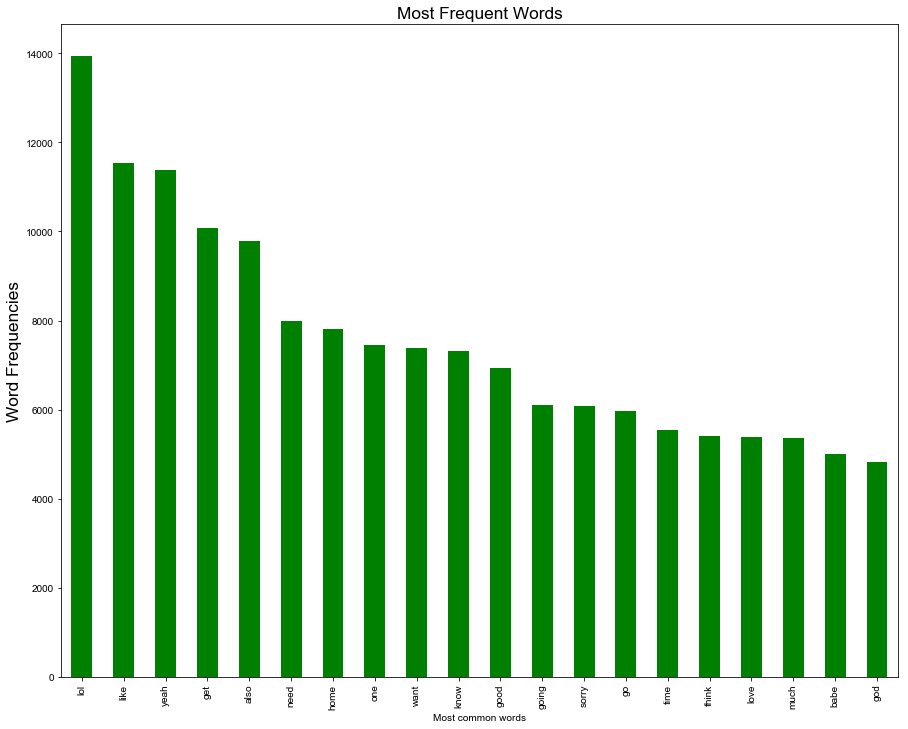

In [14]:
make_df(counter.most_common(20), size)['Absolute Frequency'].plot(kind='bar', figsize=(15,12), color='green')
plt.title('Most Frequent Words', fontsize='xx-large')
plt.ylabel('Word Frequencies', fontsize='xx-large')
plt.style.use('seaborn-darkgrid');

<a id='wordcloud'></a>
### Creating Wordcloud
***
Now for the best part. This is actually a pretty straightforward task that simply requires utilizing the wordcloud library. All I had to do was write a quick function that would import the desired mask, generate the object, and save the output.

In [15]:
!pip install wordcloud
from wordcloud import WordCloud
!pip install PIL
from PIL import Image
import os

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [16]:
def create_wordcloud(text):
    mask = np.array(Image.open(os.path.join(path, 'Heart Mask.jpg')))
    
    wc = WordCloud(mask=mask, background_color='black', stopwords=esw).generate(text)
    wc.to_file(os.path.join(path, 'Word Cloud.jpg'))

In [17]:
create_wordcloud(texts)

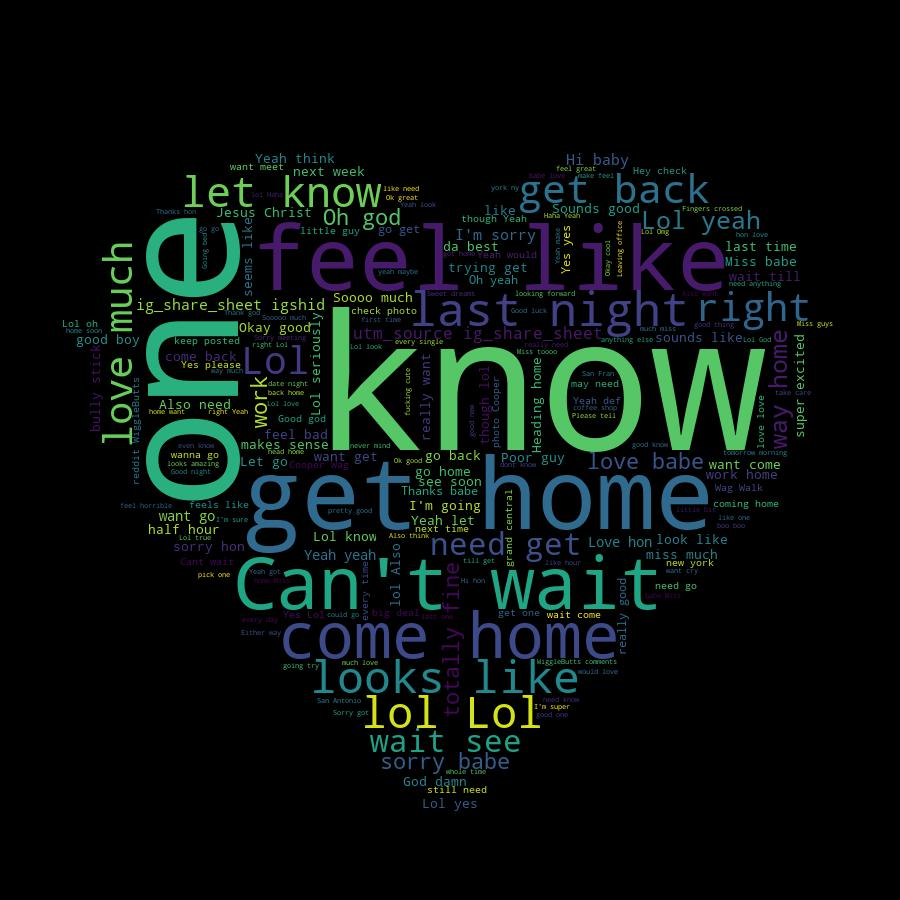

In [18]:
from IPython.display import Image
Image(filename='Word Cloud.jpg') 

<a id='conclusion'></a>
## Conclusion
---

I'm a little surprised to see "love" isn't higher, but at least we laugh a lot :) I can spot a few other words and pieces of conjunctions, as well as few cases of the same word being counted seperately due to different case (Lol & lol). So there is definitely some fine-tuning with the stopwords for me to do later. But overall, this was an extremely satisfying experience. It was a great opportunity to utilize a newly learned technique to explore data I am passionate about. The end result was just a beautiful bonus.